# Analyzing NYC's Stormwater Flood Map - Extreme Flood Scenario
## Objective: Data Cleaning, Inspection and Removing Polygons Less Than 0.25 Acres
Note: I'm only examining flood polygons greater than or equal to 0.25 acres for this project.

Mark Bauer

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request
import zipfile 
import matplotlib.patches as mpatches
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

An IPython magic extension for printing date and time stamps, version numbers, and hardware information.  
Source: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,seaborn,matplotlib,geopandas

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
seaborn   : 0.11.2
matplotlib: 3.5.2
geopandas : 0.11.1



![nyc-opendata-dashboard](images/nyc-opendata-dashboard.png)

Screenshot of the data on NYC Open Data.  
Source: https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Extreme-Flood-with-2080-S/w8eg-8ha6

![data-description](images/data-description.png)

Screenshot of data description.  
Source: https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Extreme-Flood-with-2080-S/w8eg-8ha6

In [4]:
# download data from nyc open data using urllib package

# url path from the web
url = 'https://data.cityofnewyork.us/download/w8eg-8ha6/application%2Fzip'
file_name = 'data/stormwater-data-nyc.zip'

# assigning file name as 'stormwater-data-nyc.zip''
urllib.request.urlretrieve(url, file_name)

# sanity check of data
%ls data/

buildings-hazard.csv     nta-hazard.csv           stormwater-data-source/
daily-precipitation.csv  stormwater-data-nyc.zip  stormwater-data.zip


In [5]:
path = 'data/stormwater-data-nyc.zip'
directory = 'data/stormwater-data-source'

# open zip file
with zipfile.ZipFile(path, 'r') as file:
    # extracting all items in our zipfile
    file.extractall(directory)

# list items
%ls data/stormwater-data-source/    

NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.gdb/
NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.xlsx


In [6]:
# copy data dictionary to top-level directory
!cp 'data/stormwater-data-source/NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.xlsx' .

# sanity check of data dictionary
%ls

CONTRIBUTING.md
LICENSE
NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.xlsx
README.md
analysis.ipynb
data/
data-cleaning.ipynb
figures/
images/
precipitation-data.ipynb
spatial-joins.ipynb


In [7]:
# reading in data
path = 'data/stormwater-data-source/NYC Stormwater Flood Map - Extreme Flood with 2080 Sea Level Rise.gdb'
gdf = gpd.read_file(path)

# sanity check
print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (3, 4)


,Flooding_Category,Shape_Length,Shape_Area,geometry
0,1,3.264384e+07,3.972152e+08,"MULTIPOLYGON Z (((917206.497 120931.611 0.000,..."
1,2,1.656489e+07,3.054550e+08,"MULTIPOLYGON Z (((917270.790 120873.747 0.000,..."
2,3,8.042525e+06,3.455846e+08,"MULTIPOLYGON Z (((915290.556 120269.389 0.000,..."


The data is grouped by flood category. To have each row as an individual polygon, we need to explode these nested values into separate rows per polygon.

![data-dictionary](images/data-dictionary.png)

Screenshot of data dictionary.

In [8]:
# summary of the data
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Flooding_Category  3 non-null      int64   
 1   Shape_Length       3 non-null      float64 
 2   Shape_Area         3 non-null      float64 
 3   geometry           3 non-null      geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 224.0 bytes


In [9]:
# examine crs
gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
# examine geom types
gdf.geom_type

0    MultiPolygon
1    MultiPolygon
2    MultiPolygon
dtype: object

<AxesSubplot:>

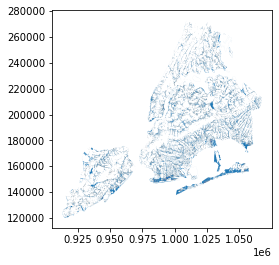

In [11]:
# examine plot
gdf.plot()

`Flooding_Category`: Category of flooding classified by depth of ponding or tidal inundation from sea level rise.


>1 - Nuisance Flooding (greater or equal to 4 in. and less than 1 ft.)  
>2 - Deep and Contiguous Flooding (1 ft. and greater)  
>3 - Future High Tides 2080

Source: Data dictionary.

In [12]:
# examine flood category codes
gdf.head()

,Flooding_Category,Shape_Length,Shape_Area,geometry
0,1,3.264384e+07,3.972152e+08,"MULTIPOLYGON Z (((917206.497 120931.611 0.000,..."
1,2,1.656489e+07,3.054550e+08,"MULTIPOLYGON Z (((917270.790 120873.747 0.000,..."
2,3,8.042525e+06,3.455846e+08,"MULTIPOLYGON Z (((915290.556 120269.389 0.000,..."


In [13]:
# mapping flood category codes to classifications, easier to read
codes_dict = {
    1:'Nuisance Flooding',
    2:'Deep and Contiguous Flooding',
    3:'Future High Tides 2080'
}

# add new column for flood classification
gdf['flood_classification'] = gdf['Flooding_Category'].replace(codes_dict)

# sanity check
print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (3, 5)


,Flooding_Category,Shape_Length,Shape_Area,geometry,flood_classification
0,1,3.264384e+07,3.972152e+08,"MULTIPOLYGON Z (((917206.497 120931.611 0.000,...",Nuisance Flooding
1,2,1.656489e+07,3.054550e+08,"MULTIPOLYGON Z (((917270.790 120873.747 0.000,...",Deep and Contiguous Flooding
2,3,8.042525e+06,3.455846e+08,"MULTIPOLYGON Z (((915290.556 120269.389 0.000,...",Future High Tides 2080


In [14]:
# explode multipolygon so every row is a single polygon
gdf = (
    gdf
    .explode()
    .reset_index(drop=True)
)

# calculating area and length of geometries
gdf['Shape_Area'] = gdf.area 
gdf['Shape_Length'] = gdf.length 

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (145429, 5)


,Flooding_Category,Shape_Length,Shape_Area,flood_classification,geometry
0,1,51.436905,165.359700,Nuisance Flooding,"POLYGON Z ((917206.497 120931.611 0.000, 91720..."
1,1,37.622059,79.460913,Nuisance Flooding,"POLYGON Z ((917309.366 120950.899 0.000, 91730..."
2,1,14.432754,4.925173,Nuisance Flooding,"POLYGON Z ((917309.366 120950.899 0.000, 91730..."
3,1,54.817201,154.010850,Nuisance Flooding,"POLYGON Z ((917277.219 120938.040 0.000, 91726..."
4,1,24.392395,14.030167,Nuisance Flooding,"POLYGON Z ((917311.973 120963.757 0.000, 91730..."


In [16]:
# sanity check for geom types values
gdf.geom_type.value_counts()

Polygon    145429
dtype: int64

In [17]:
# examine CRS
gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
cols = [
    'Flooding_Category',
    'flood_classification', 
    'Shape_Length',
    'Shape_Area',
    'geometry'
]

# rearrange column order
gdf = gdf.loc[:, cols]

# preview data
gdf.head()

,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry
0,1,Nuisance Flooding,51.436905,165.359700,"POLYGON Z ((917206.497 120931.611 0.000, 91720..."
1,1,Nuisance Flooding,37.622059,79.460913,"POLYGON Z ((917309.366 120950.899 0.000, 91730..."
2,1,Nuisance Flooding,14.432754,4.925173,"POLYGON Z ((917309.366 120950.899 0.000, 91730..."
3,1,Nuisance Flooding,54.817201,154.010850,"POLYGON Z ((917277.219 120938.040 0.000, 91726..."
4,1,Nuisance Flooding,24.392395,14.030167,"POLYGON Z ((917311.973 120963.757 0.000, 91730..."


In [19]:
# examine count of polygons by flood classifications
(gdf
 .groupby(by='flood_classification')[['flood_classification']]
 .count()
 .rename(columns={'flood_classification':'count_polygons'})
 .reset_index()
)

,flood_classification,count_polygons
0,Deep and Contiguous Flooding,39742
1,Future High Tides 2080,7122
2,Nuisance Flooding,98565


In [20]:
# examine flooded area by flood classifications
acres_conversion = 43560

(gdf
 .groupby(by='flood_classification')[['Shape_Area']]
 .sum()
 .div(acres_conversion)
 .round(0)
 .astype(int)
 .rename(columns={'Shape_Area':'shape_area_acres'})
 .reset_index()
)

,flood_classification,shape_area_acres
0,Deep and Contiguous Flooding,7012
1,Future High Tides 2080,7934
2,Nuisance Flooding,9119


In [21]:
# examine flooded area min, max by flood classifications
acres_conversion = 43560

(gdf
 .groupby(by='flood_classification')[['Shape_Area']]
 .agg({'Shape_Area': ['min', 'max']})
 .div(acres_conversion)
 .rename(columns={'Shape_Area':'shape_area_acres'})
 .reset_index()
)

flood_classification shape_area_acres             
                                             min          max
0  Deep and Contiguous Flooding     1.186102e-09    68.154537
1        Future High Tides 2080     4.305792e-09  1266.198909
2             Nuisance Flooding     1.174981e-09    50.153468

In [22]:
# a quick sanity check with small polygons < 0.25 acres
acres_conversion = 43560
ser = gdf['Shape_Area'] / acres_conversion

perc_count = round(ser.loc[ser < .25].shape[0] / ser.shape[0] * 100, 2)
perc_area = round(ser.loc[ser < .25].sum() / ser.sum() * 100, 2)

print('polygons less than 0.25 acres:\n-----')
print('count: {}% of total'.format(perc_count))
print('area: {}% of total'.format(perc_area))

polygons less than 0.25 acres:
-----
count: 91.72% of total
area: 13.31% of total


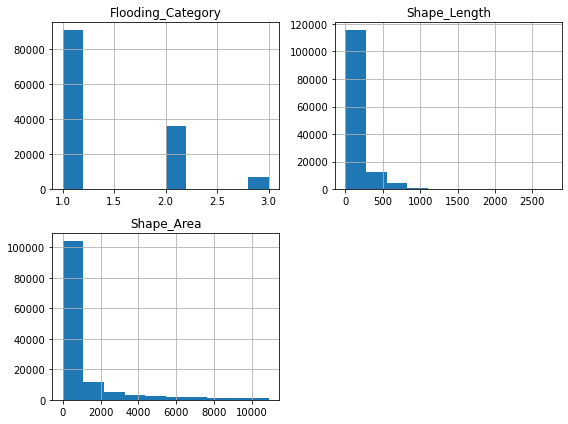

In [23]:
acres_conversion = 43560

(gdf
 .loc[gdf['Shape_Area'] / acres_conversion < .25]
 .hist(figsize=(8, 6))
)

# note: units are still displayed as square feet in plots
plt.tight_layout()

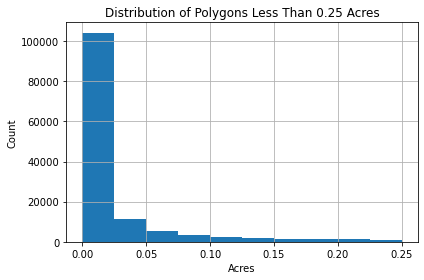

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

acres_conversion = 43560
hist_gdf = gdf['Shape_Area'] / acres_conversion

(hist_gdf
 .loc[hist_gdf < 0.25]
 .hist(ax=ax)
)

plt.title('Distribution of Polygons Less Than 0.25 Acres')
plt.xlabel('Acres')
plt.ylabel('Count')
plt.tight_layout()

In [26]:
# removing polygons with less than 0.25 acres of flooding
acres_conversion = 43560

gdf = (
    gdf
    .loc[gdf['Shape_Area'] / acres_conversion >= .25]
    .reset_index(drop=True)
)

print('shape of data: {}'.format(gdf.shape))
gdf.head()

shape of data: (12036, 5)


,Flooding_Category,flood_classification,Shape_Length,Shape_Area,geometry
0,1,Nuisance Flooding,1695.857677,27852.535494,"POLYGON Z ((916393.149 121765.469 0.000, 91640..."
1,1,Nuisance Flooding,1532.269198,18338.901687,"POLYGON Z ((917251.502 121381.664 0.000, 91725..."
2,1,Nuisance Flooding,2327.963831,32127.388341,"POLYGON Z ((916251.188 121441.271 0.000, 91625..."
3,1,Nuisance Flooding,3830.095703,48711.665246,"POLYGON Z ((917377.109 122108.195 0.000, 91739..."
4,1,Nuisance Flooding,4600.270710,65321.650657,"POLYGON Z ((918159.499 121451.773 0.000, 91814..."


In [27]:
# sanity check (acres)
acres_conversion = 43560
ser = gdf.loc[:, ['Shape_Area']] / acres_conversion

# examining summary statistics of flood area
ser.describe()

,Shape_Area
count,12036.000000
mean,1.733295
std,15.038070
min,0.250030
25%,0.347283
50%,0.538978
75%,1.048261
max,1266.198909


<AxesSubplot:>

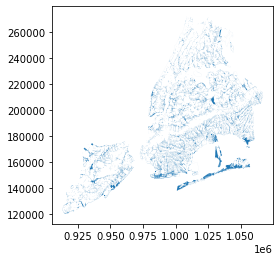

In [28]:
# sanity check
gdf.plot()

In [29]:
# save file
gdf.to_file(
    'data/stormwater-data.gpkg',
    driver='GPKG',
    layer='name',
    index=False
)

%ls data/

buildings-hazard.csv     stormwater-data-nyc.zip  stormwater-data.zip
daily-precipitation.csv  stormwater-data-source/
nta-hazard.csv           stormwater-data.gpkg


In [30]:
# zip .gpkg into zip folder
!zip data/stormwater-data.zip data/stormwater-data.gpkg

%ls data/

updating: data/stormwater-data.gpkg (deflated 63%)
buildings-hazard.csv     stormwater-data-nyc.zip  stormwater-data.zip
daily-precipitation.csv  stormwater-data-source/
nta-hazard.csv           stormwater-data.gpkg


In [31]:
# remove copies of data to save storage
!rm data/stormwater-data.gpkg data/stormwater-data-nyc.zip

%ls data/

buildings-hazard.csv     nta-hazard.csv           stormwater-data.zip
daily-precipitation.csv  stormwater-data-source/
